# Predicting House Prices

In [25]:
# Import the necessary modules and libraries
import pandas as pd 

import seaborn as sns

import matplotlib.pyplot as plt

import numpy as np

from math import sqrt

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor


## Import data

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
test_data_submission = pd.read_csv('sample_submission.csv')


## Clean data

In [3]:
def cleaning(dataframe):
    """
    This function corrects any missing values in a pandas dataframe
    returns the cleaned dataframe
    """
    
    # loop through all the features/columns in the training data
    for column in dataframe:

        # check whether the data in each column is numerical
        if is_numeric_dtype(dataframe[column]):

            # if the data is numerical compute the mean of the whole column values
            column_mean = dataframe[column].mean()

            # replace the missing values in this column with the mean of the column
            dataframe[column] = dataframe[column].fillna(column_mean)

        # also replace categorical missing values
        # check this approach!
        else:
            dataframe[column] = dataframe[column].fillna(dataframe[column].value_counts().index[0])
    
    return dataframe


## One hot encode categorical data

In [4]:
def one_hot_encoding(df):
    
    """One hot encode categorical data from a dataframe."""
        
    # select all categorical features
    cat_data = df.select_dtypes(include=[object])
    num_data = df.select_dtypes(exclude=[object])
    
    # create a LabelEncoder object and apply it to each categorical feature in the data
    le = preprocessing.LabelEncoder()
    cat_data_2 = cat_data.apply(le.fit_transform)
    
    # create a OneHotEncoder object and fit it to all categorical data
    enc = preprocessing.OneHotEncoder()
    enc.fit(cat_data_2)
    onehotlabels = enc.transform(cat_data_2).toarray()
    
    # get all possible categories from the data
    all_categories = enc.get_feature_names(cat_data_2.columns)

    # create new dataframe with all possible categories as columns
    cat_data = pd.DataFrame(onehotlabels, columns = all_categories)
    
    num_data = num_data.set_index('Id')
    
    # merge the numerical data with the one hot encoded categorical data again
    result = pd.concat([cat_data, num_data], axis=1).reindex(cat_data.index)
        
    return result


## Redivide the dataset

In [5]:
def shuffle_data(train_data_df, test_data_df, test_data_submission_df):
    """
    Function to randomly shuffle the train and test data
    """
    # drop the house Id, as this is already in the test_data_df
    test_data_submission_df = test_data_submission_df.drop('Id', axis=1)

    # add the saleprice (y) to the test data
    test_data_df.insert(80, "SalePrice", test_data_submission_df, True)
        
    # 'glue' the test data and train data together
    total_df = pd.concat([train_data_df, test_data_df])
    
    # one hot encode categorical data in dataframe
    total_df_oh = one_hot_encoding(total_df)   
    
    # clean data in dataframe
    total_df_cleaned = cleaning(total_df_oh)
    
    # shuffle the data randomly
    total_df = shuffle(total_df_cleaned)
    
    # create SalePrice list
    y = total_df['SalePrice'].tolist()

    # remove the Saleprice from the total dataframe 
    X = total_df.drop('SalePrice', axis=1)

    # split between test data and train data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = shuffle_data(train_data, test_data, test_data_submission)


/Users/veerleblom/opt/anaconda3/envs/progLab/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Visualize sale prices

/Users/veerleblom/opt/anaconda3/envs/progLab/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/veerleblom/opt/anaconda3/envs/progLab/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

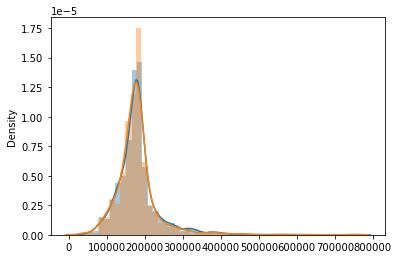

In [6]:
# create histogram with seaborn of the Sale price (y) from train and test data
sns.distplot(y_train)
sns.distplot(y_test)

## Regression tree

In [26]:
# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X_train, y_train)

# Predict
y_pred1 = regr_1.predict(X_test)

# Compute root mean squared error 
rmse = np.sqrt(mean_squared_error(y_pred1, y_test))
print("RMSE:", rmse)

# Visualize the Decision Tree
text_representation = tree.export_text(regr_1)
print(text_representation)


RMSE: 45417.542800771764
|--- feature_290 <= 1613.00
|   |--- feature_290 <= 1158.50
|   |   |--- feature_280 <= 1950.50
|   |   |   |--- feature_4 <= 0.50
|   |   |   |   |--- feature_14 <= 0.50
|   |   |   |   |   |--- value: [99161.53]
|   |   |   |   |--- feature_14 >  0.50
|   |   |   |   |   |--- value: [127314.75]
|   |   |   |--- feature_4 >  0.50
|   |   |   |   |--- feature_277 <= 11760.00
|   |   |   |   |   |--- value: [154399.38]
|   |   |   |   |--- feature_277 >  11760.00
|   |   |   |   |   |--- value: [80500.00]
|   |   |--- feature_280 >  1950.50
|   |   |   |--- feature_287 <= 905.50
|   |   |   |   |--- feature_290 <= 681.00
|   |   |   |   |   |--- value: [84700.00]
|   |   |   |   |--- feature_290 >  681.00
|   |   |   |   |   |--- value: [141743.57]
|   |   |   |--- feature_287 >  905.50
|   |   |   |   |--- feature_277 <= 10670.50
|   |   |   |   |   |--- value: [153589.75]
|   |   |   |   |--- feature_277 >  10670.50
|   |   |   |   |   |--- value: [171465.73]


In [27]:
# Fit regression model
regr_2 = DecisionTreeRegressor(max_depth=4)
regr_2.fit(X_train, y_train)

# Predict
y_pred2 = regr_2.predict(X_test)

# Compute root mean squared error 
rmse = np.sqrt(mean_squared_error(y_pred2, y_test))
print("RMSE:", rmse)

# Visualize the Decision Tree
text_representation = tree.export_text(regr_2)
print(text_representation)

RMSE: 44980.466485984856
|--- feature_290 <= 1613.00
|   |--- feature_290 <= 1158.50
|   |   |--- feature_280 <= 1950.50
|   |   |   |--- feature_4 <= 0.50
|   |   |   |   |--- value: [117349.01]
|   |   |   |--- feature_4 >  0.50
|   |   |   |   |--- value: [150962.20]
|   |   |--- feature_280 >  1950.50
|   |   |   |--- feature_287 <= 905.50
|   |   |   |   |--- value: [139405.72]
|   |   |   |--- feature_287 >  905.50
|   |   |   |   |--- value: [157934.11]
|   |--- feature_290 >  1158.50
|   |   |--- feature_280 <= 1993.50
|   |   |   |--- feature_277 <= 28681.00
|   |   |   |   |--- value: [162129.26]
|   |   |   |--- feature_277 >  28681.00
|   |   |   |   |--- value: [234598.44]
|   |   |--- feature_280 >  1993.50
|   |   |   |--- feature_286 <= 1416.00
|   |   |   |   |--- value: [179313.74]
|   |   |   |--- feature_286 >  1416.00
|   |   |   |   |--- value: [199962.27]
|--- feature_290 >  1613.00
|   |--- feature_278 <= 7.50
|   |   |--- feature_290 <= 2020.50
|   |   |   |---

## Random forest regression

In [8]:
regressor = RandomForestRegressor(n_estimators = 80, random_state = 0)
regressor.fit(X_train.values, y_train)

y_pred = regressor.predict(X_test)

# compute root mean squared error 
rmse = np.sqrt(mean_squared_error(y_pred, y_test))
print("RMSE:", rmse)


RMSE: 37254.672331524416


/Users/veerleblom/opt/anaconda3/envs/progLab/lib/python3.7/site-packages/sklearn/base.py:439: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
